# Donwload Dataset

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [65]:
os.chdir('/content/')
!git clone https://github.com/freds0/capybara_dataset

fatal: destination path 'capybara_dataset' already exists and is not an empty directory.


# Data Augmentation for Object Detection using ImgAug

Documentation: https://imgaug.readthedocs.io

In [66]:
# https://nbviewer.org/github/aleju/imgaug-doc/blob/master/notebooks/B02%20-%20Augment%20Bounding%20Boxes.ipynb
!pip install -U imageio imgaug
!pip3 install --upgrade Pillow

In [67]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa 
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import pandas as pd
%matplotlib inline

In [68]:
ia.seed(42)

In [80]:
data = pd.read_csv('/content/capybara_dataset/data/train_labels.csv')

In [81]:
data

filename  width  height     class  xmin  ymin  xmax  ymax
0     65.jpeg    299     169  capivara     1    57   234   169
1    125.jpeg    183     275  capivara    38    95   150   268
2    125.jpeg    183     275  capivara    47    42    93    96
3     58.jpeg    354     142  capivara     8    42    65    73
4     58.jpeg    354     142  capivara    68    35   122    67
..        ...    ...     ...       ...   ...   ...   ...   ...
304   40.jpeg    225     225  capivara    71   148   153   215
305   40.jpeg    225     225  capivara   155   134   214   204
306   40.jpeg    225     225  capivara   125   133   164   172
307   40.jpeg    225     225  capivara    48   109    85   142
308   79.jpeg    206     245  capivara    51   118   206   245

[309 rows x 8 columns]

In [82]:
#data = data.sort_values('filename').drop_duplicates('filename', keep='last')
#data

In [83]:
one_data_example = data.sample(n=1)
filename = one_data_example.iloc[0]['filename']

In [84]:
data_example = data[data['filename'] == filename]
data_example

filename  width  height     class  xmin  ymin  xmax  ymax
218  60.jpeg    259     194  capivara   134    72   184   120
219  60.jpeg    259     194  capivara   182   112   259   180
220  60.jpeg    259     194  capivara    37   143   163   194
221  60.jpeg    259     194  capivara     1   105    35   159
222  60.jpeg    259     194  capivara     1    31    38   102
223  60.jpeg    259     194  capivara    39     1    71    32
224  60.jpeg    259     194  capivara    84    25   129   101
225  60.jpeg    259     194  capivara   206     1   247    51

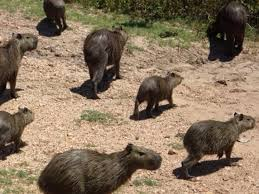

In [85]:
from IPython.display import Image, display
import os
filepath = os.path.join('/content/capybara_dataset/images/train', filename)          
display(Image(filename=filepath))

In [86]:
image = imageio.imread(filepath)
#image = ia.imresize_single_image(image, (298, 447))
#plt.imshow(image)

In [87]:
values = []

for index, row in data_example.iterrows():
    values.append(BoundingBox(
        x1=row['xmin'],
        x2=row['xmax'],
        y1=row['ymin'],
        y2=row['ymax']
    ))

In [88]:
values

[BoundingBox(x1=134.0000, y1=72.0000, x2=184.0000, y2=120.0000, label=None),
 BoundingBox(x1=182.0000, y1=112.0000, x2=259.0000, y2=180.0000, label=None),
 BoundingBox(x1=37.0000, y1=143.0000, x2=163.0000, y2=194.0000, label=None),
 BoundingBox(x1=1.0000, y1=105.0000, x2=35.0000, y2=159.0000, label=None),
 BoundingBox(x1=1.0000, y1=31.0000, x2=38.0000, y2=102.0000, label=None),
 BoundingBox(x1=39.0000, y1=1.0000, x2=71.0000, y2=32.0000, label=None),
 BoundingBox(x1=84.0000, y1=25.0000, x2=129.0000, y2=101.0000, label=None),
 BoundingBox(x1=206.0000, y1=1.0000, x2=247.0000, y2=51.0000, label=None)]

In [89]:
bbs = BoundingBoxesOnImage(values, shape=image.shape)

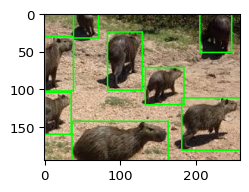

In [90]:
ia.imshow(bbs.draw_on_image(image, size=2))

# Color Augmentations

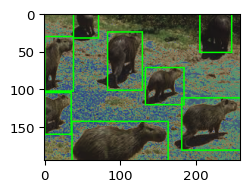

In [91]:
seq = iaa.Sequential([
    iaa.GammaContrast((0.3, 3)),        
    iaa.LinearContrast((0.8, 1.2)),     
    iaa.AddToHueAndSaturation((-10, 10)),
    iaa.Invert(0.5),                              # Invert in 50% of all images all pixels:
    iaa.Solarize(0.5, threshold=(32, 128))        # Invert all values above a threshold in images. Ex. invert the colors in 50 percent of all images for pixels with a value between 32 and 128 or more
])
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

# Localization Augmentations

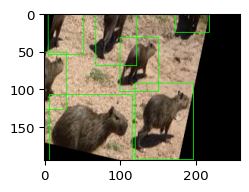

In [92]:
seq = iaa.Sequential([
    iaa.Affine(
         scale={"x": (0.5, 1.5), "y": (0.5, 1.5)},                     # Scale images to a value of 50 to 150% of their original size:
         translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},       # Translate images by -20 to +20% on x- and y-axis independently:
         rotate=(-45, 45),                                             # Rotate images by -45 to 45 degrees:
         shear=(-16, 16),                                              # Shear images by -16 to 16 degrees:         
    )
])
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))

# Deformation Augmentations

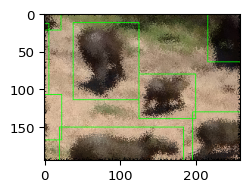

In [93]:
seq = iaa.Sequential([
    iaa.PiecewiseAffine(scale=(0.01, 0.03)),                # Apply affine transformations that differ between local neighbourhoods.
    iaa.PerspectiveTransform(scale=(0.01, 0.15)),           # Apply random four point perspective transformations to images.
    iaa.ElasticTransformation(alpha=(3.0, 5.0), sigma=0.25),  # Transform images by moving pixels locally around using displacement fields.

])
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))


# Dropout Augmentations

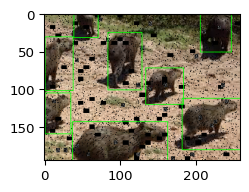

In [94]:
seq = iaa.Sequential([
    iaa.Dropout(p=0.05),                           # Augmenter that sets a certain fraction of pixels in images to zero.
    iaa.CoarseDropout((0.01,0.05), size_percent=(0.1, 0.2)),          # Augmenter that sets rectangular areas within images to zero.
    iaa.CoarsePepper((0.01,0.05), size_percent=(0.1, 0.2)),  # Replace rectangular areas in images with black-ish pixel noise.
    #iaa.TotalDropout(0.1)                               # Drop all channels of a defined fraction of all images.
])

image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))

# Noise Augmentations

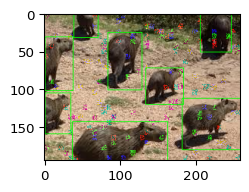

In [95]:
seq = iaa.Sequential([
    #iaa.Add((-40, 40), per_channel=0.5),                    # Add random values between -40 and 40 to images. In 50% of all images the values differ per channel (3 sampled value)
    #iaa.AddElementwise((-40, 40), per_channel=0.5)          # Add values to the pixels of images with possibly different values for neighbouring pixels.    
    #iaa.ImpulseNoise((0.05, 0.1)),                           # Add impulse noise to images.
    #iaa.AdditiveGaussianNoise(scale=(20, 30)),                # Add noise sampled from poisson distributions elementwise to images.
    #iaa.AdditiveLaplaceNoise(scale=0.1*255),           # Add noise sampled from laplace distributions elementwise to images.
    #iaa.Salt((0.05, 0.1)),                                          # Replace pixels in images with salt noise, i.e. white-ish pixels.
    #iaa.CoarseSalt((0.01,0.05), size_percent=(0.1, 0.2)),         # Replace rectangular areas in images with white-ish pixel noise.
    #iaa.Pepper((0.05, 0.1)),                                        # Replace pixels in images with pepper noise, i.e. black-ish pixels.
    #iaa.CoarsePepper((0.01,0.05), size_percent=(0.1, 0.2)),       # Replace rectangular areas in images with black-ish pixel noise.
    #iaa.SaltAndPepper((0.05, 0.1)),                                 # Replace pixels in images with salt/pepper noise (white/black-ish colors).
    #iaa.CoarseSaltAndPepper((0.01,0.05), size_percent=(0.1, 0.2)),# Replace rectangular areas in images with white/black-ish pixel noise.
    iaa.CoarseSaltAndPepper((0.01,0.05), 
        size_percent=(0.1, 0.2), per_channel=True
    )       
])

image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))



# Degradation Augmentation

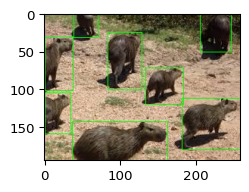

In [96]:
seq = iaa.Sequential([
    #iaa.JpegCompression(compression=(80, 95)),    # Degrade the quality of images by JPEG-compressing them with a compression strength between 80 and 95
    #iaa.Alpha(                                    # Blends a canny edge image with a median-blurred version of the input image. 
    #    (0.0, 1.0),
    #    iaa.Canny(alpha=1),
    #    iaa.MedianBlur(13)
    #),
    iaa.GaussianBlur(sigma=(0.0,3.0)),            # Augmenter to blur images using gaussian kernels. Ex.: Blur each image with a gaussian kernel with a sigma of 3.0.
    #iaa.AverageBlur(k=(2, 5)),                   # Blur an image by computing simple means over neighbourhoods.
    #iaa.MedianBlur(k=(3, 5)),                    # Blur an image by computing median values over neighbourhoods. 
    #iaa.BilateralBlur(                            # Blur/Denoise an image using a bilateral filter.
    #    d=(3, 10), sigma_color=(10, 250), sigma_space=(10, 250)
    #),
    #iaa.MotionBlur(k=(5,10)),                          # Blur images in a way that fakes camera or object movements.
    #iaa.MeanShiftBlur(),                           # Apply a pyramidic mean shift filter to each image.        
])
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))



# Flip

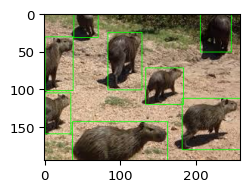

In [97]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Flip/mirror input images horizontally. Ex.: Flip 50% of all images horizontally.
    #iaa.Flipud(0.5)  # Flip/mirror input images vertically.
])

image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))



# Weather Augmentations

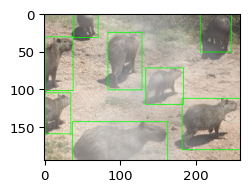

In [98]:
seq = iaa.Sequential([
    #iaa.FastSnowyLandscape(             # Convert non-snowy landscapes to snowy ones.
    #    lightness_threshold=[100, 150],
    #    lightness_multiplier=(1.1, 3.5)
    #), 
    iaa.Clouds(),                        # Add clouds to images.
    #iaa.Fog(),                            # Add fog to images.
    #iaa.Snowflakes(flake_size=(0.3, 0.95), speed=(0.001, 0.03)) # Add falling snowflakes to images.
    #iaa.Rain(speed=(0.1, 0.3))
])
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))    

# Lambda Function

Augmenter that calls a lambda function for each batch of input image.

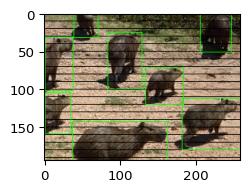

In [99]:
# Replace in every image each 10 row with black pixels:
def img_func_horizontal(images, random_state, parents, hooks):
    for img in images:
        img[::10] = 0
    return images

# Replace in every image each 10 cols with black pixels:
def img_func_vertical(images, random_state, parents, hooks):
    for img in images:
        img[:,::10] = 0
        #print(img.shape)
    return images

def keypoint_func(keypoints_on_images, random_state, parents, hooks):
    return keypoints_on_images

aug = iaa.Lambda(img_func_horizontal, keypoint_func)

image_aug, bbs_aug = aug(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))

# Augmentation Selection

## SomeOf

List augmenter that applies only some of its children to images. Ex.: Apply two of four given augmenters.

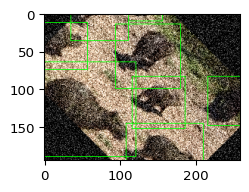

In [100]:
aug = iaa.SomeOf(2, [
    iaa.Affine(rotate=45),
    iaa.AdditiveGaussianNoise(scale=0.2*255),
    iaa.Add(50, per_channel=True),
    iaa.Sharpen(alpha=0.5)
])
image_aug, bbs_aug = aug(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))    

# OneOf

Augmenter that always executes exactly one of its children. Ex.: Apply one of four augmenters to each image.

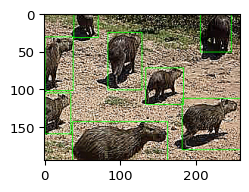

In [101]:
aug = iaa.OneOf([
    iaa.Affine(rotate=45),
    iaa.AdditiveGaussianNoise(scale=0.2*255),
    iaa.Add(50, per_channel=True),
    iaa.Sharpen(alpha=0.5)
])
image_aug, bbs_aug = aug(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))    

# Sometimes

Augment only p percent of all images with one or more augmenters.. Ex.: Apply gaussian blur to about 50% of all images.

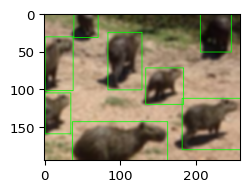

In [102]:
import imgaug.augmenters as iaa

aug = iaa.Sometimes(0.5, 
        iaa.GaussianBlur(sigma=2.0)
)
image_aug, bbs_aug = aug(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))   

# Data Augmentation at Furnas Dataset

In [103]:
import os
import cv2
import pandas as pd
import tqdm
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import imgaug as ia


# specify augmentations that will be executed on each image randomly
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    #iaa.Flipud(0.2), # vertical flip
    iaa.Sometimes(
        0.1,    
        iaa.Snowflakes()
    ),
    iaa.Sometimes(
        0.1,    
        iaa.Clouds()
    ),
    iaa.Sometimes(
        0.5,    
        iaa.Crop(percent=(0, 0.3)), # random crops
    ),

    iaa.Sometimes(
        0.1,
        iaa.CoarseDropout((0.0, 0.2), size_px=8)
    ),

    iaa.Sometimes(
        0.5,
        iaa.GammaContrast((0.5, 2.0))
    ),
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.05))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.8, 1.2)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),

    iaa.Sometimes(
        0.1,
        iaa.AddToHueAndSaturation((-10, 10))
    ),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.95, 1.05), per_channel=0.25),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
         scale={"x": (1, 1.3), "y": (1, 1.3)},
         translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
         rotate=(-3, 3),
    )],
    random_order=True) # apply augmenters in random order# apply augmenters in random order


def aug_image(filename: str, df: pd.DataFrame, folder: str, augmentations: int) -> (list, list):
    """
    This function will:
     1. load the image based on the filename from the given folder
     2. load all given bounding boxes to that image from the given DataFrame
     3. apply augmentations specified by the seq variable above
     4. output images and bounding_boxes
    :param filename: str object that defines the image to be augmented
    :param df: DataFrame that stores all given bounding box information to each image
    :param folder: defines where to find the image
    :param augmentations: defines the number of augmentations to be done
    :return: list of augmented images, list of bouding_boxes for each augmented image
    """
    # load image
    img = cv2.imread(os.path.join(folder, filename))
    # create empty list for bounding_boxes
    bbs = list()
    # iterate over DataFrame to get each bounding box for that image
    for _, row in df[df.filename == filename].iterrows():
        x1 = row.xmin
        y1 = row.ymin
        x2 = row.xmax
        y2 = row.ymax
        bbs.append(BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=row['class']))
    # concatenate all bounding boxes fro that image
    bbs = BoundingBoxesOnImage(bbs, shape=img.shape[:-1])

    # replicate the image augmentations times
    images = [img for _ in range(augmentations)]
    # replicate the bounding boxes augmentations times
    bbss = [bbs for _ in range(augmentations)]

    # augment images with bounding_boxes
    image_aug, bbs_aug = seq(images=images, bounding_boxes=bbss)

    return image_aug, bbs_aug


def save_augmentations(images: list, bbs: list, df: pd.DataFrame, filename: str, folder: str, resize: bool = False,
                       shape: (int, int) = (None, None)) -> pd.DataFrame:
    """
    This function will:
    1. store each augmented image in a new folder
    2. append the bounding_boxes from the augmented_images to the given DataFrame
    :param images: list of augmented images
    :param bbs: list of concatanted bounding boxes that relate to an augmentated image
    :param df: DataFrame that will store the information about the new bounding boxes from the augmented images
    :param filename: original filename of the original image
    :param folder: str object that defines the path to the output folder for the augmentated images
    :param resize: defines if the image should be resized or not after the augmentation
    :param shape: if the image will be reshaped, it will be reshaped into this shape
    :return: DataFrame
    """

    # iterate over the images
    for [i, img_a], bb_a in zip(enumerate(images), bbs):
        # define new name
        new_filename = os.path.basename(filename).replace('.jpeg', '')
        aug_img_name = f'{new_filename}_data_aug.jpeg'
        # check if image should be resized
        org_shape = (None, None)
        if resize:
            org_shape = img_a.shape[:-1]
            img_a = cv2.resize(img_a, shape, interpolation=cv2.INTER_NEAREST)

        # clean bb_a --> use only bounding boxes that are still in the frame (cropping can lead to bounding boxes being
        # removed from the images)
        bb_a = bb_a.remove_out_of_image().clip_out_of_image()
        # iterate over the bounding boxes
        at_least_one_box = False
        for bbs in bb_a:
            if resize:
                bbs = bbs.project(org_shape, shape)
            arr = bbs.compute_out_of_image_fraction(img_a)
            if arr < 0.8:
                at_least_one_box = True
                x1 = int(bbs.x1)
                y1 = int(bbs.y1)
                x2 = int(bbs.x2)
                y2 = int(bbs.y2)
                c = bbs.label
                # append extracted data to the DataFrame
                height, width = img_a.shape[:-1]
                df = df.append(pd.DataFrame(data=[aug_img_name, width, height, c, x1, y1, x2, y2],
                                            index=df.columns.tolist()).T)
        if at_least_one_box:
            # save image at specified folder
            cv2.imwrite(os.path.join(folder, aug_img_name), img_a)

    return df

In [104]:
  # specify folder
  folder = 'train'
  # define number of augmentations per image
  augmentations = 1
  # specify if the image should be resized
  resize = False
  # define shape (should be equal to requested shape of the object detection model
  new_shape = (1280, 720)
  # define input folder
  input_folder = os.path.join('/content/capybara_dataset/images/', folder)
  # define and create output_folder
  output_folder = os.path.join('/content/capybara_dataset/images/', f'{folder}_aug')
  if not os.path.isdir(output_folder):
      os.makedirs(output_folder)
  # 1. get a list of all images in the folder
  img_list = [img for img in os.listdir(input_folder) if img.endswith('.jpeg')]

  # 2. load DataFrame with annotations
  df = pd.read_csv(os.path.join('/content/capybara_dataset/data/', 'train_labels.csv'))
  # create a new pandas table for the augmented images' bounding boxes
  aug_df = pd.DataFrame(columns=df.columns.tolist())

  # 2. iterate over the images and augmentate them
  for filename in tqdm.tqdm(img_list):
      # augment image
      aug_images, aug_bbs = aug_image(filename, df, input_folder, augmentations)
      # store augmentations in new DataFrame and save image
      aug_df = save_augmentations(aug_images, aug_bbs, aug_df, filename, output_folder, resize, new_shape)

  # save new DataFrame
  aug_df.to_csv(os.path.join('/content/capybara_dataset/images/', f'{folder}_aug.csv'))

100%|██████████| 178/178 [00:03<00:00, 45.91it/s]


In [105]:
new_data = pd.read_csv('/content/capybara_dataset/images/train_aug.csv')
data_examples = new_data.sample(n=10)
filenames = []
for index, row in data_examples.iterrows():
  filenames.append(os.path.join('/content/capybara_dataset/images/train_aug', row['filename']))

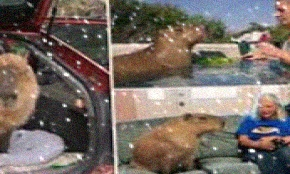

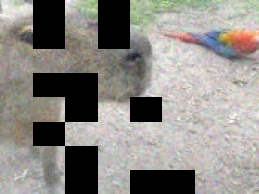

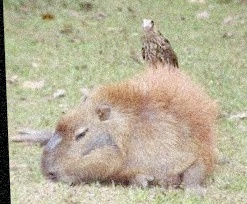

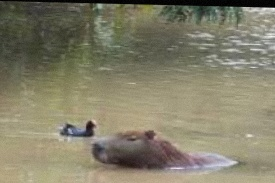

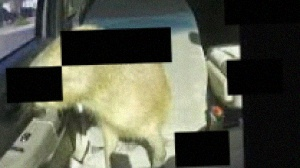

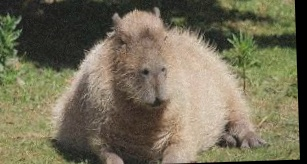

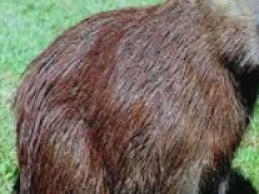

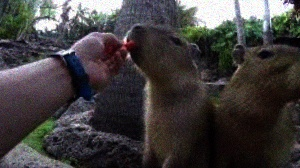

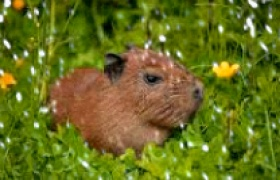

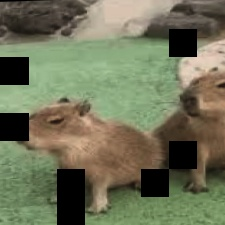

In [106]:
from IPython.display import Image, display
for filename in filenames:
    display(Image(filename=filename))

In [107]:
import numpy as np
def get_image_with_box(img: np.ndarray, img_name: str, df: pd.DataFrame) -> np.ndarray:
    """
    This function will:
    1. get all bounding boxes that relate to the image for the DataFrame
    2. concatenate them with imgaug package to a BoundingBoxesOnImage object
    3. draw the Bounding boxes onto the image
    :param img: image as np array
    :param img_name: filename to locate the bounding boxes in the df
    :param df: DataFrame that holds the information about all bounding boxes
    :return: image with bounding boxes drawn onto it
    """
    # create bounding box with imgaug
    img_boxs = df[df.filename == img_name]

    bbs = list()
    for _, row in img_boxs.iterrows():
        x1 = row.xmin
        y1 = row.ymin
        x2 = row.xmax
        y2 = row.ymax
        bbs.append(BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2))

    # convert single bounding boxes to BOundingBoxOnImage instance to draw it on the picture
    bbs = BoundingBoxesOnImage(bbs, img.shape[:-1])

    # draw image
    img = bbs.draw_on_image(img)

    return img

def create_comparison_plot(aug_df: pd.DataFrame, aug_img_name: str, df: pd.DataFrame, img_name: str, folder: str):
    """
    This function will:
    1. load the bounding boxes of the augmented images and draw them on the aug_image
    2. do the same with original image
    3. make them side by side on comparison subpot
    :param aug_df: DataFrame that holds all bounding boxes for augmented image
    :param aug_img_name: str object to locate bounding boxes in DataFrame
    :param df: DataFrame that holds all bounding boxes for image
    :param img_name: str object to locate bounding boxes in DataFrame
    :param folder: str object that defines the folders where to find the images
    """
    aug_folder = os.path.join('/content/capybara_dataset/images/', f'{folder}_aug')
    # load augmented image
    aug_img = cv2.imread(os.path.join('/content/capybara_dataset/images/', aug_folder, aug_img_name))
    aug_img = get_image_with_box(aug_img, aug_img_name, aug_df)

    aug_img = aug_img[:, :, [2, 1, 0]]

    org_folder = os.path.join('/content/capybara_dataset/images/', folder)
    # load augmented image
    org_img = cv2.imread(os.path.join('/content/capybara_dataset/images/', org_folder, img_name))
    org_img = get_image_with_box(org_img, img_name, df)

    org_img = org_img[:, :, [2, 1, 0]]

    fig, axs = plt.subplots(1, 2, figsize=[20, 10])

    ax = axs[0]
    ax.imshow(org_img)
    ax.set_title('original image')
    ax.axis('off')

    ax = axs[1]
    ax.imshow(aug_img)
    ax.set_title('augmented image')
    ax.axis('off')



80_data_aug.jpeg


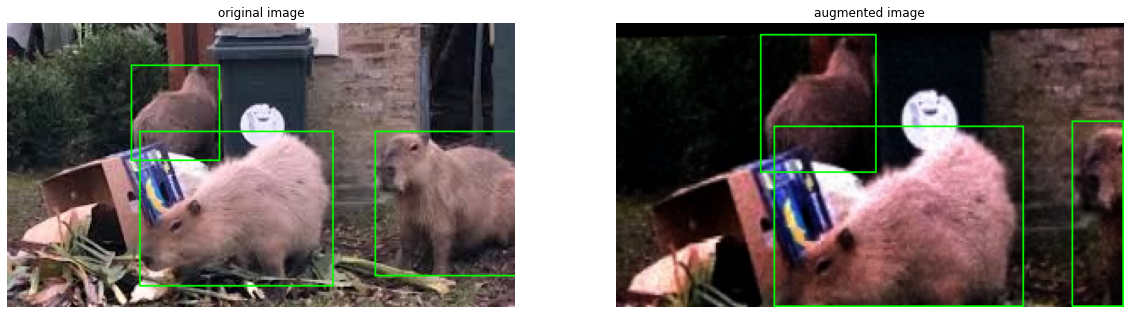

75_data_aug.jpeg


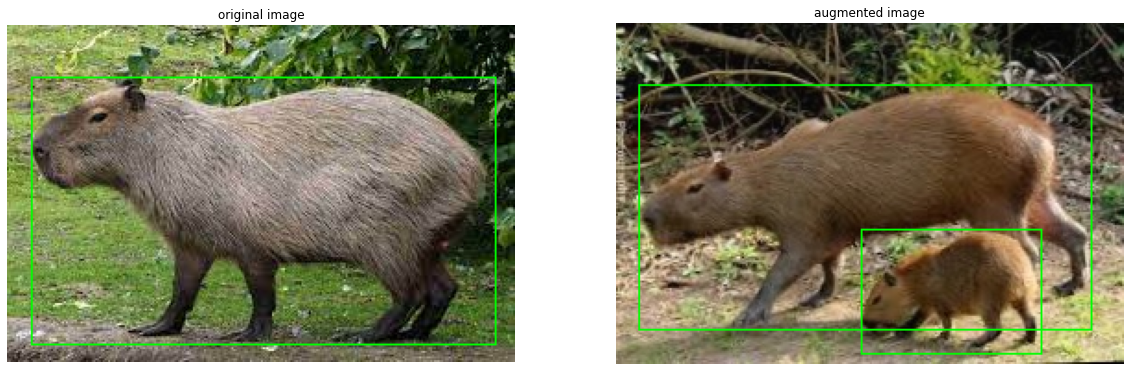

11_data_aug.jpeg


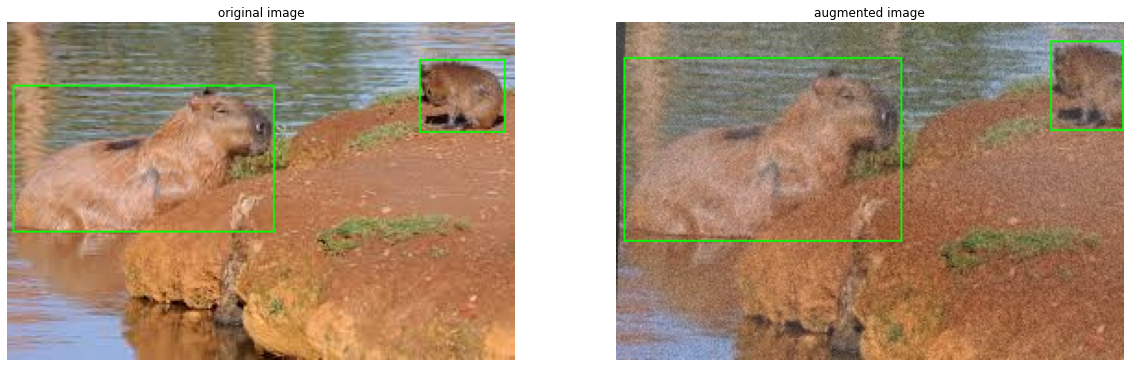

154_data_aug.jpeg


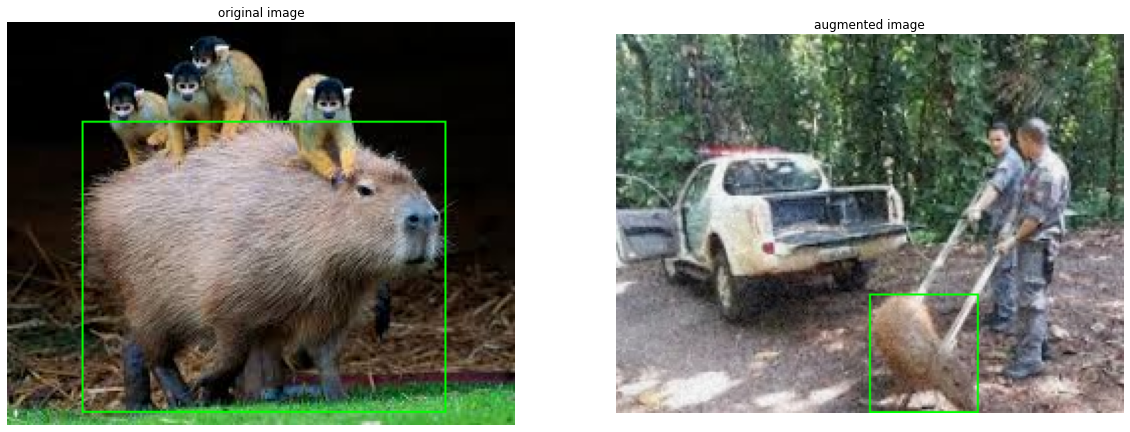

38_data_aug.jpeg


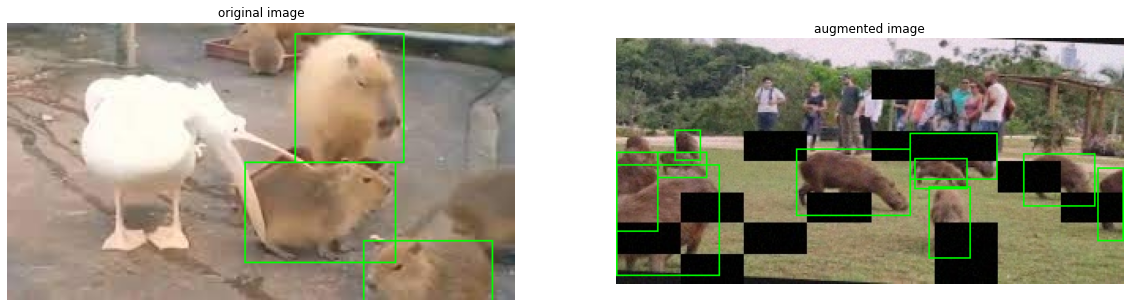

166_data_aug.jpeg


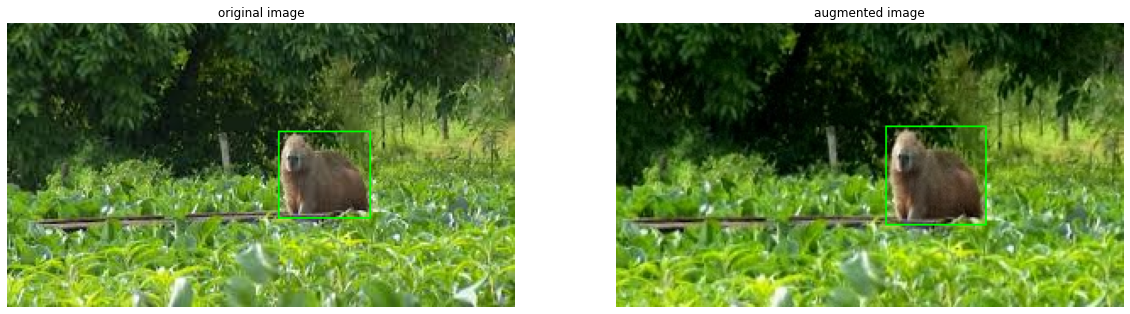

87_data_aug.jpeg


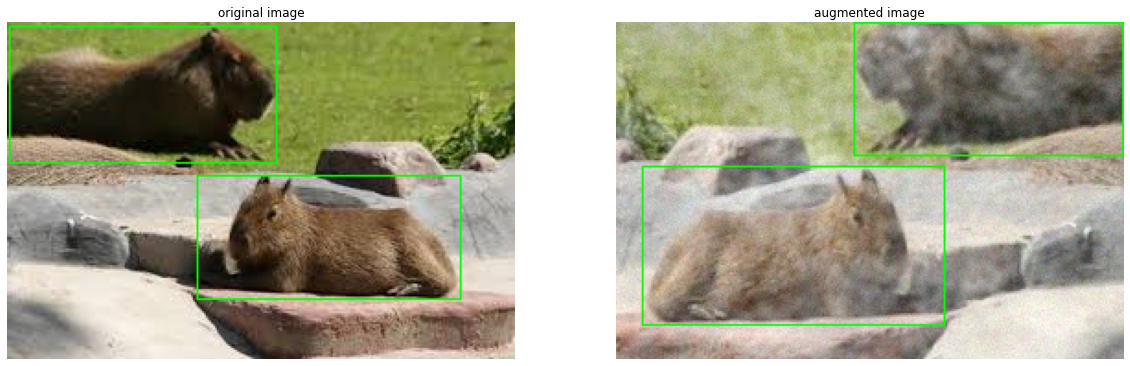

45_data_aug.jpeg


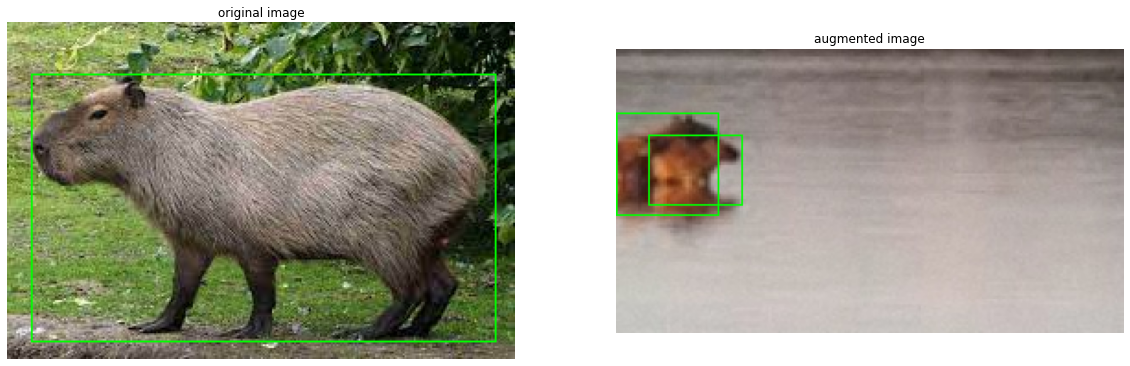

111_data_aug.jpeg


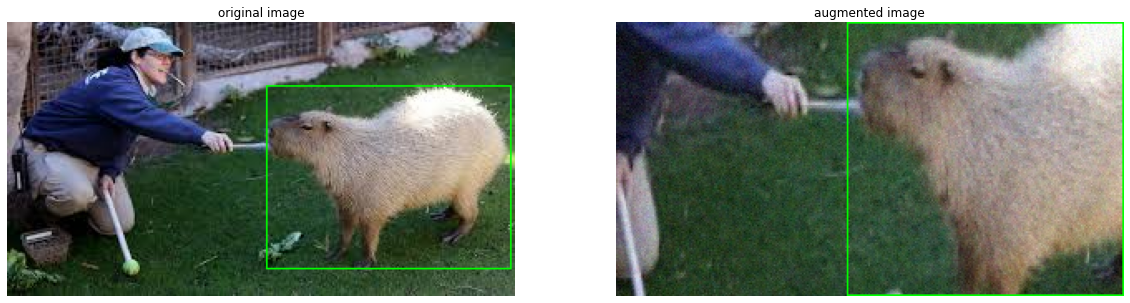

156_data_aug.jpeg


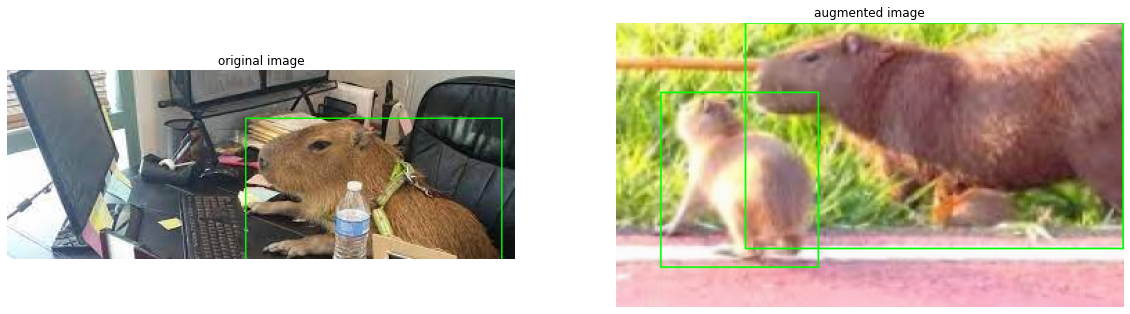

In [111]:
import os
import pandas as pd
import random
import cv2
from matplotlib import pyplot as plt

# define folder
folder = 'train'
# load df_aug to pick a random image from it
aug_df = pd.read_csv(os.path.join('/content/capybara_dataset/images/', f'{folder}_aug.csv'))

for i in range(10):
  # pick a random image from the table
  rand_idx = random.sample(range(aug_df.shape[0]), 1)[0]
  img_aug_name = aug_df.loc[rand_idx, 'filename']
  print(img_aug_name)
  # get original image name
  img_name = [img for img in os.listdir(os.path.join('/content/capybara_dataset/images/', folder)) if img in img_aug_name.replace('_data_aug.jpeg', '.jpeg')]
  # check if image exist
  if img_name:
      img_name = img_name[0]
  else:
      raise FileNotFoundError()

  # load df with original image bounding box information
  df = pd.read_csv(os.path.join('/content/capybara_dataset/data/', 'train_labels.csv'))

  create_comparison_plot(aug_df, img_aug_name, df, img_name, folder)

  plt.show()